## Importing Library and dataset

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [91]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airline_passenger_timeseries.csv')

## Data Prepartion

In [92]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [93]:
df.shape

(144, 2)

In [94]:
df.isnull().sum()

,0
Month,0
Passengers,0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [96]:
fig = px.line(df,
              x='Month',
              y='Passengers',
              title='Monthly Airline Passengers (1949-1960)',
              labels={'year': 'Year', 'Passengers': 'Number of Passengers'})

fig.update_layout(
    xaxis=dict(showgrid=True, title="Year"),
    yaxis=dict(showgrid=True, title="Number of Passengers"),
    template="plotly_white"
)

fig.show()

In [97]:
df['year']=pd.to_datetime(df['Month']).dt.year
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

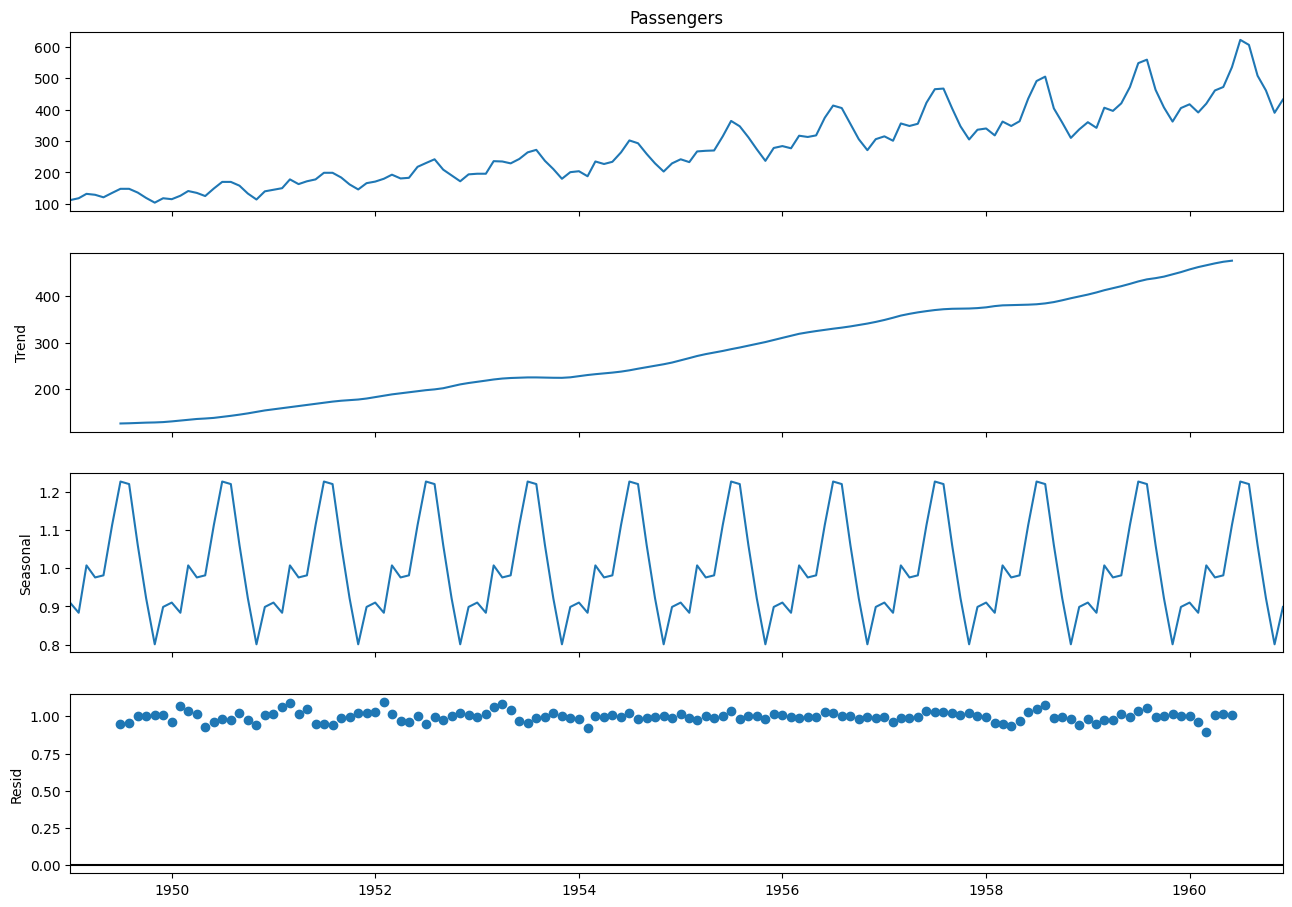

In [99]:
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [100]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


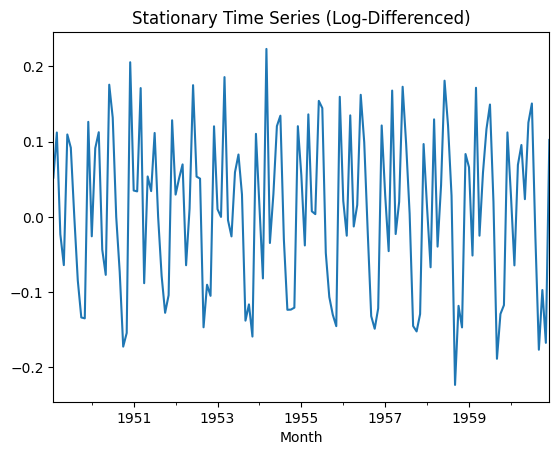

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [101]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

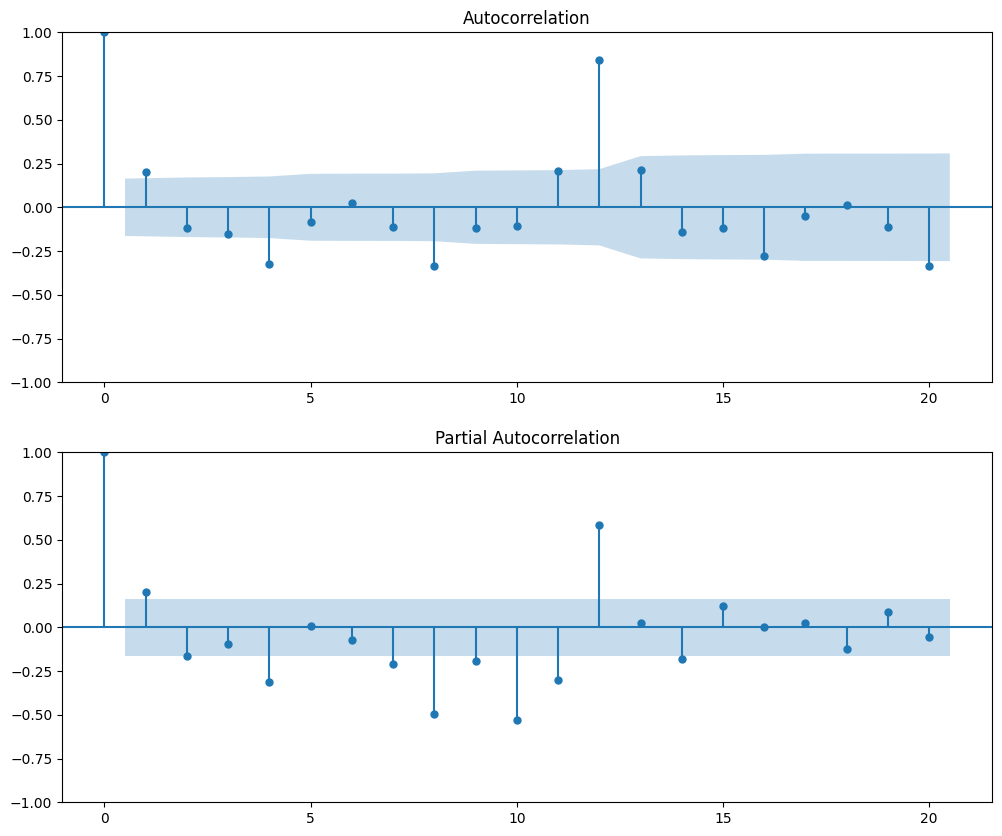

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

## Model Evaluation

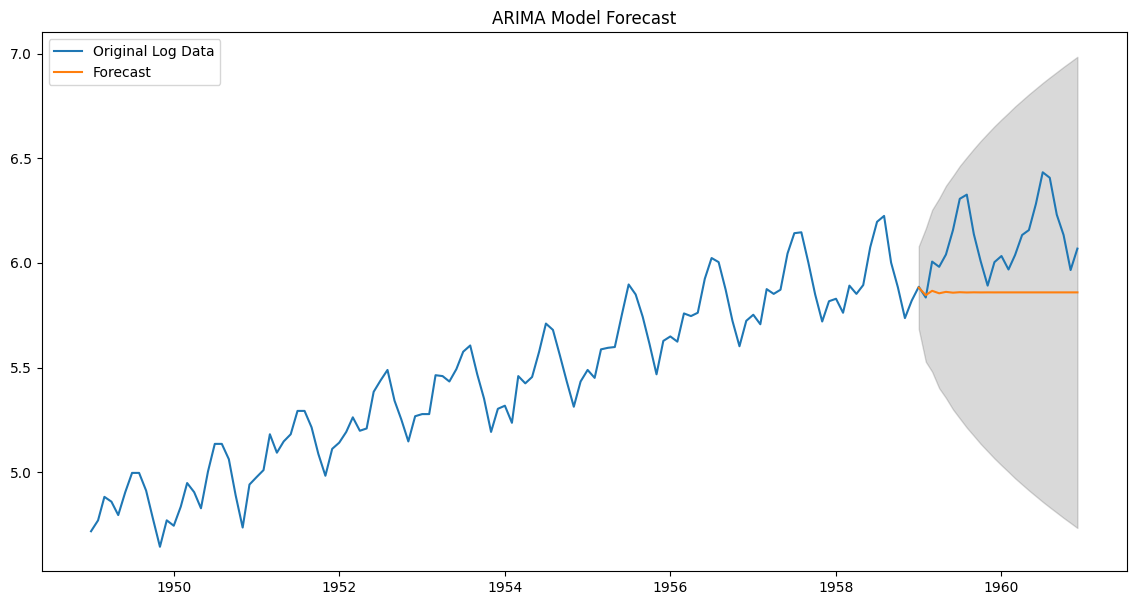

In [103]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

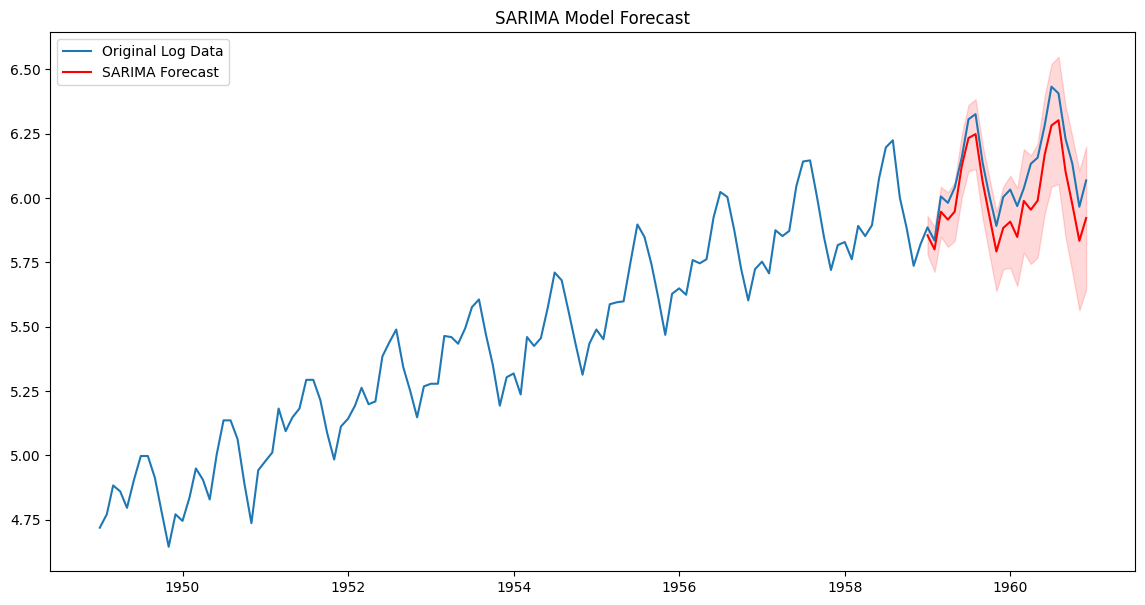

In [104]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

## Final Evaluation

SARIMA Model RMSE: 48.25


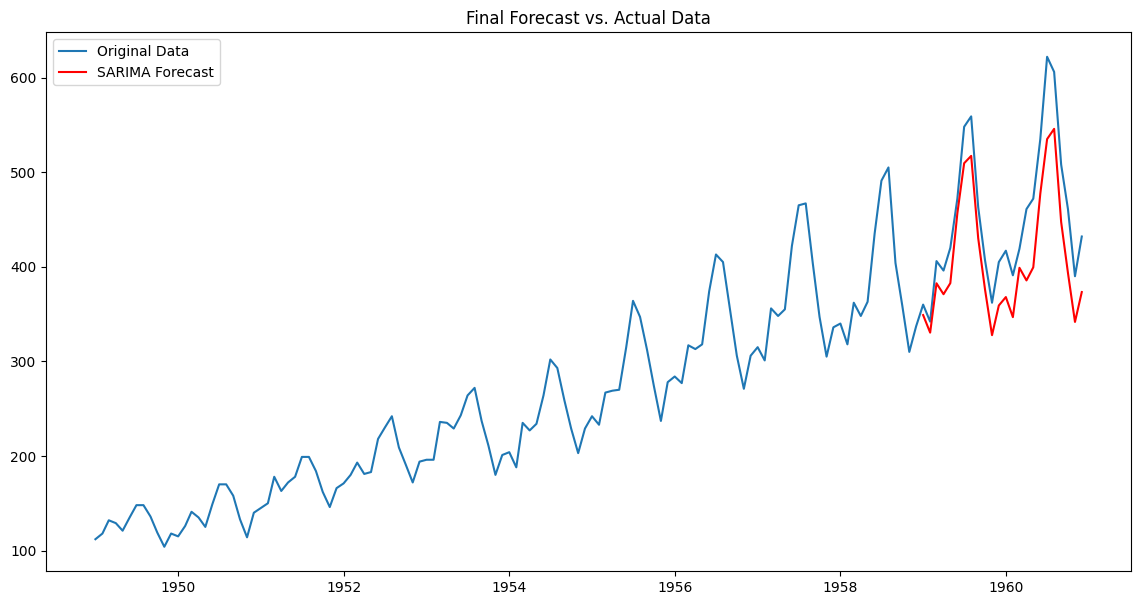

In [105]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

In [98]:
df.head()

,Passengers,year
Month,,
1949-01-01,112,1949
1949-02-01,118,1949
1949-03-01,132,1949
1949-04-01,129,1949
1949-05-01,121,1949


## Assignment